<a href="https://colab.research.google.com/github/lemonyun/keras_study/blob/main/3_6_predicting_house_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
keras.__version__

'2.7.0'

In [2]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

65536/57026 [==================================] - 0s 0us/step


In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

In [5]:
train_targets


array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

데이터 전처리 과정

방법 1. 특성별로 정규화
입력 데이터에 있는 각 특성(입력 데이터 행렬의 열)에 대해서 특성의 평균을 빼고

표준 편차로 나누기. 넘파이 함수로 할수 있음

테스트 데이터를 정규화할때 훈련 데이터의 평균값과 표준편차를 사용

In [6]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

샘플의 개수가 적기 때문에 64개의 유닛을 가진 두 개의 은닉층으로 작은 네트워크를 구성하여 사용하겠습니다. 일반적으로 훈련 데이터의 개수가 적을수록 과대적합이 더 쉽게 일어나므로 작은 모델을 사용하는 것이 과대적합을 피하는 한 방법입니다.

마지막 출력층이 활성화 함수가 없음

이는 스칼라 회귀를 위한 구성임

시그모이드 함수를 적용한다면 0과 1 사이의 값을 예측하도록 학습됨

회귀 문제에서 널리 사용되는 손실 함수는 평균 제곱 오차(MSE)

In [22]:
from keras import models
from keras import layers

def build_model():
    # 동일한 모델을 여러 번 생성할 것이므로 함수를 만들어 사용합니다
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

K-겹 검증을 사용한 훈련 검증 (데이터 포인트가 많이 없을경우 사용할 수 있는 방법)

In [8]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # 검증 세트로 모델 평가
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [10]:
len(train_data) // 4

101

In [11]:
train_data

array([[-0.27224633, -0.48361547, -0.43576161, ...,  1.14850044,
         0.44807713,  0.8252202 ],
       [-0.40342651,  2.99178419, -1.33391162, ..., -1.71818909,
         0.43190599, -1.32920239],
       [ 0.1249402 , -0.48361547,  1.0283258 , ...,  0.78447637,
         0.22061726, -1.30850006],
       ...,
       [-0.40202987,  0.99079651, -0.7415148 , ..., -0.71712291,
         0.07943894, -0.67776904],
       [-0.17292018, -0.48361547,  1.24588095, ..., -1.71818909,
        -0.98764362,  0.42083466],
       [-0.40422614,  2.04394792, -1.20161456, ..., -1.30866202,
         0.23317118, -1.15392266]])

In [12]:
all_scores

[2.1235971450805664, 2.69803786277771, 2.5405681133270264, 2.7451679706573486]

평균 2500달러 정도의 오차

In [13]:
np.mean(all_scores)

2.526842772960663

In [14]:
from keras import backend as K

# 메모리 해제
K.clear_session()

In [23]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [24]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [25]:
import matplotlib.pyplot as plt

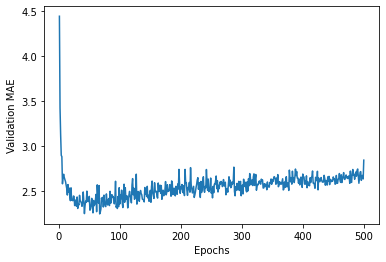

In [26]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

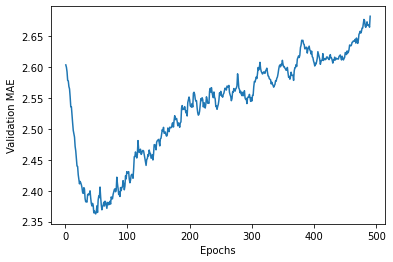

In [27]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

50 에포크 까지는 MAE가 줄어드는데 이 지점 이후로는 과대적합이 시작됨

과대적합을 막는 방법은 은닉 층의 수를 줄이는 방법이 있다. (일반적으로 하나 또는 두개)

In [30]:
# 새롭게 컴파인된 모델을 얻습니다
model = build_model()
# 전체 데이터로 훈련시킵니다
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 4ms/step - loss: 13.6501 - mae: 2.4255


In [31]:
test_mae_score

2.425457000732422